SVM_RGBW_train

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # <-- Make sure this is properly aligned
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm


# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_combined_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_", "w_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per image type
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

# ------------------- Classifier -------------------
def train_with_random_forest(features, labels, title="Multichannel RGBW"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)


import joblib  # <-- Add at top if not already

def train_with_svm(features, labels, title="Multichannel RGBW - SVM", save_dir=None):
    print(f"\n📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all = []
    truths_all = []

    clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)

    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title}):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        joblib.dump(clf, os.path.join(save_dir, "svm_model.pkl"))
        joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))
        joblib.dump(le, os.path.join(save_dir, "label_encoder.pkl"))
        print(f"💾 Model, scaler, and label encoder saved in: {save_dir}")



if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"
    SVM_MODEL_DIR = r"H:\Granulosa_data_1\vipul_annotation_1\SVM_model"  # <-- Where to save SVM model

    print("🔍 Extracting unified RGBW features...")
    X_all, y_all = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_all:
        print("❌ No features found for RGBW.")
    else:
        train_with_svm(X_all, y_all, title="Multichannel RGBW - SVM", save_dir=SVM_MODEL_DIR)


SVM_RGBW_val

In [ ]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Validation for SVM -------------------
def validate_svm_model_with_subfolders(image_root, json_path, model_dir, mode="RGBW"):
    print(f"\n🔍 Extracting validation features for mode: {mode}...")

    all_modes = {
        "RGBW": ["r_", "g_", "b_", "w_"],
        "RGB": ["r_", "g_", "b_"],
        "W": ["w_"]
    }
    image_types = all_modes[mode]
    categories = ["n_ovary", "h_nc", "tumour"]

    coco_data = load_coco_json(json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(image_root):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per channel
                    all_features.append(feat_list)
                    all_labels.append(cat)

    if not all_features:
        print(f"❌ No features found in test set.")
        return

    print(f"📊 {mode} | Validating on {len(all_features)} regions...")

    # Load model, scaler, and label encoder
    clf = joblib.load(os.path.join(model_dir, "svm_model.pkl"))
    scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
    le = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))

    # Preprocess features
    X = scaler.transform(all_features)
    y_true = le.transform(all_labels)

    # Predict
    y_pred = clf.predict(X)

    # Report results
    print("\n✅ Classification Report on Validation Set:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"Validation Confusion Matrix (SVM - {mode})")
    plt.tight_layout()
    plt.show()

# ------------------- Entry Point -------------------
if __name__ == "__main__":
    TEST_FOLDER = r"H:\ML_MSI\ROI_based\val_data"
    TEST_JSON = r"H:\ML_MSI\ROI_based\val_data\annotation_27_05_25_vipul_3.json"
    MODEL_DIR = r"H:\ML_MSI\ROI_based\SVM_model"  # Ensure this folder contains svm_model.pkl etc.

    validate_svm_model_with_subfolders(TEST_FOLDER, TEST_JSON, MODEL_DIR, mode="RGBW")


SVM_RGB

🔍 Extracting unified RGBW features...

📊 Multichannel RGBW - SVM | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [27 27 27]

✅ Final Classification Report (Multichannel RGBW - SVM):
              precision    recall  f1-score   support

        h_nc       0.78      0.83      0.80        81
     n_ovary       0.68      0.58      0.63        81
      tumour       0.78      0.85      0.82        81

    accuracy                           0.75       243
   macro avg       0.75      0.75      0.75       243
weighted avg       0.75      0.75      0.75       243



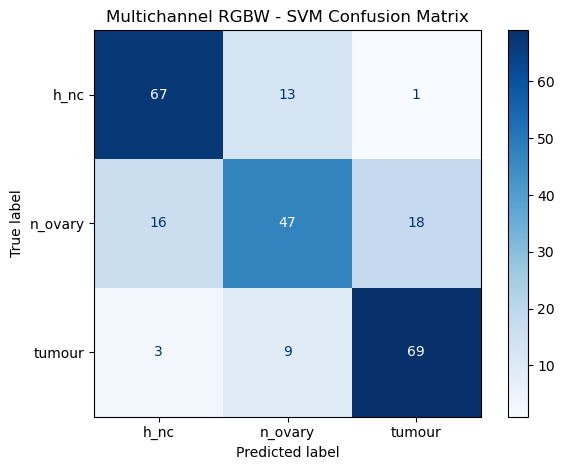

💾 Model, scaler, and label encoder saved in: H:\ML_MSI\ROI_based\SVM_RGB


In [3]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # <-- Make sure this is properly aligned
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm


# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_combined_features(root_folder, coco_json_path):
    image_types = ["r_", "g_", "b_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per image type
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

# ------------------- Classifier -------------------
def train_with_random_forest(features, labels, title="Multichannel RGBW"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)


import joblib  # <-- Add at top if not already

def train_with_svm(features, labels, title="Multichannel RGBW - SVM", save_dir=None):
    print(f"\n📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all = []
    truths_all = []

    clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)

    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title}):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        joblib.dump(clf, os.path.join(save_dir, "svm_model.pkl"))
        joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))
        joblib.dump(le, os.path.join(save_dir, "label_encoder.pkl"))
        print(f"💾 Model, scaler, and label encoder saved in: {save_dir}")



if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"
    SVM_MODEL_DIR = r"H:\ML_MSI\ROI_based\SVM_RGB"  # <-- Where to save SVM model

    print("🔍 Extracting unified RGBW features...")
    X_all, y_all = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_all:
        print("❌ No features found for RGBW.")
    else:
        train_with_svm(X_all, y_all, title="Multichannel RGBW - SVM", save_dir=SVM_MODEL_DIR)


SVM_RGB VAlidation


🔍 Extracting validation features for mode: RGB...
📊 RGB | Validating on 16 regions...

✅ Classification Report on Validation Set:
              precision    recall  f1-score   support

        h_nc       0.50      0.43      0.46         7
     n_ovary       0.40      0.33      0.36         6
      tumour       0.40      0.67      0.50         3

    accuracy                           0.44        16
   macro avg       0.43      0.48      0.44        16
weighted avg       0.44      0.44      0.43        16



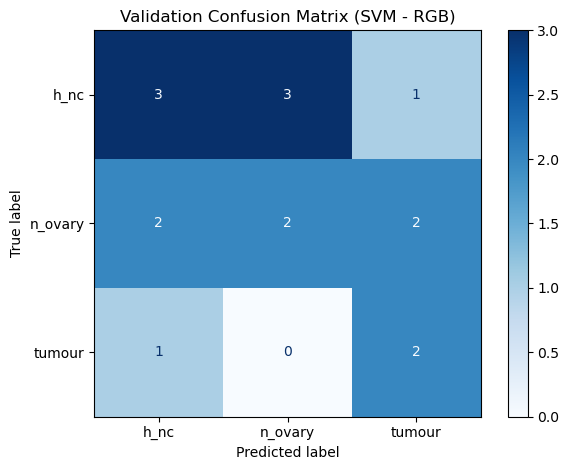

In [6]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Validation for SVM -------------------
def validate_svm_model_with_subfolders(image_root, json_path, model_dir, mode="RGB"):
    print(f"\n🔍 Extracting validation features for mode: {mode}...")

    all_modes = {
        "RGBW": ["r_", "g_", "b_", "w_"],
        "RGB": ["r_", "g_", "b_"],
        "W": ["w_"]
    }
    image_types = all_modes[mode]
    categories = ["n_ovary", "h_nc", "tumour"]

    coco_data = load_coco_json(json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(image_root):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per channel
                    all_features.append(feat_list)
                    all_labels.append(cat)

    if not all_features:
        print(f"❌ No features found in test set.")
        return

    print(f"📊 {mode} | Validating on {len(all_features)} regions...")

    # Load model, scaler, and label encoder
    clf = joblib.load(os.path.join(model_dir, "svm_model.pkl"))
    scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
    le = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))

    # Preprocess features
    X = scaler.transform(all_features)
    y_true = le.transform(all_labels)

    # Predict
    y_pred = clf.predict(X)

    # Report results
    print("\n✅ Classification Report on Validation Set:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"Validation Confusion Matrix (SVM - {mode})")
    plt.tight_layout()
    plt.show()

# ------------------- Entry Point -------------------
if __name__ == "__main__":
    TEST_FOLDER = r"H:\ML_MSI\ROI_based\val_data"
    TEST_JSON = r"H:\ML_MSI\ROI_based\val_data\annotation_27_05_25_vipul_3.json"
    MODEL_DIR = r"H:\ML_MSI\ROI_based\SVM_RGB"  # Ensure this folder contains svm_model.pkl etc.

    validate_svm_model_with_subfolders(TEST_FOLDER, TEST_JSON, MODEL_DIR, mode="RGB")


SVM for W

🔍 Extracting unified RGBW features...

📊 Multichannel W - SVM | Encoding + Scaling + SMOTE...
🔢 After SMOTE: [27 27 27]

✅ Final Classification Report (Multichannel W - SVM):
              precision    recall  f1-score   support

        h_nc       0.74      0.83      0.78        81
     n_ovary       0.59      0.48      0.53        81
      tumour       0.72      0.78      0.75        81

    accuracy                           0.70       243
   macro avg       0.69      0.70      0.69       243
weighted avg       0.69      0.70      0.69       243



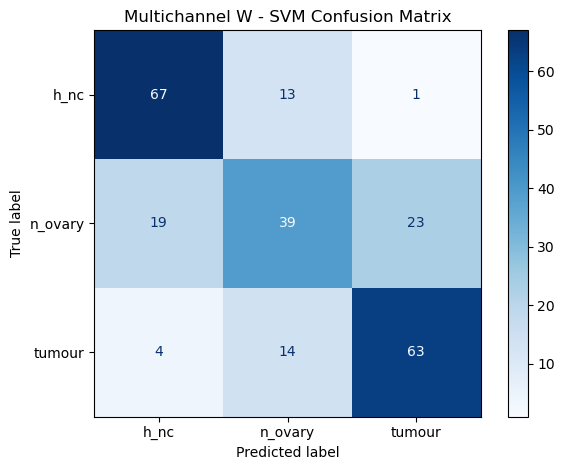

💾 Model, scaler, and label encoder saved in: H:\ML_MSI\ROI_based\SVM_W


In [7]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # <-- Make sure this is properly aligned
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from tqdm import tqdm


# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Feature Aggregation -------------------
def extract_combined_features(root_folder, coco_json_path):
    image_types = ["w_"]
    categories = ["n_ovary", "h_nc", "tumour"]
    coco_data = load_coco_json(coco_json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per image type
                    all_features.append(feat_list)
                    all_labels.append(cat)

    return all_features, all_labels

# ------------------- Classifier -------------------
def train_with_random_forest(features, labels, title="Multichannel RGBW"):
    print(f"📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)


import joblib  # <-- Add at top if not already

def train_with_svm(features, labels, title="Multichannel RGBW - SVM", save_dir=None):
    print(f"\n📊 {title} | Encoding + Scaling + SMOTE...")
    le = LabelEncoder()
    y = le.fit_transform(labels)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(features)

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print(f"🔢 After SMOTE: {np.bincount(y_resampled)}")

    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    preds_all = []
    truths_all = []

    clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)

    for train_idx, test_idx in rkf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled[train_idx], X_resampled[test_idx]
        y_train, y_test = y_resampled[train_idx], y_resampled[test_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        preds_all.extend(preds)
        truths_all.extend(y_test)

    print(f"\n✅ Final Classification Report ({title}):")
    print(classification_report(truths_all, preds_all, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        truths_all, preds_all, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"{title} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        joblib.dump(clf, os.path.join(save_dir, "svm_model.pkl"))
        joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))
        joblib.dump(le, os.path.join(save_dir, "label_encoder.pkl"))
        print(f"💾 Model, scaler, and label encoder saved in: {save_dir}")



if __name__ == "__main__":
    ROOT_IMAGE_FOLDER = r"H:\ML_MSI\ROI_based\vipul_annotation_1"
    COCO_JSON_PATH = r"H:\Granulosa_data_1\vipul_annotation_1\annotation_27_05_25_vipul_3.json"
    SVM_MODEL_DIR = r"H:\ML_MSI\ROI_based\SVM_W"  # <-- Where to save SVM model

    print("🔍 Extracting unified RGBW features...")
    X_all, y_all = extract_combined_features(ROOT_IMAGE_FOLDER, COCO_JSON_PATH)

    if not X_all:
        print("❌ No features found for RGBW.")
    else:
        train_with_svm(X_all, y_all, title="Multichannel W - SVM", save_dir=SVM_MODEL_DIR)


validation SVM_W


🔍 Extracting validation features for mode: W...
📊 W | Validating on 16 regions...

✅ Classification Report on Validation Set:
              precision    recall  f1-score   support

        h_nc       1.00      0.86      0.92         7
     n_ovary       0.75      0.50      0.60         6
      tumour       0.50      1.00      0.67         3

    accuracy                           0.75        16
   macro avg       0.75      0.79      0.73        16
weighted avg       0.81      0.75      0.75        16



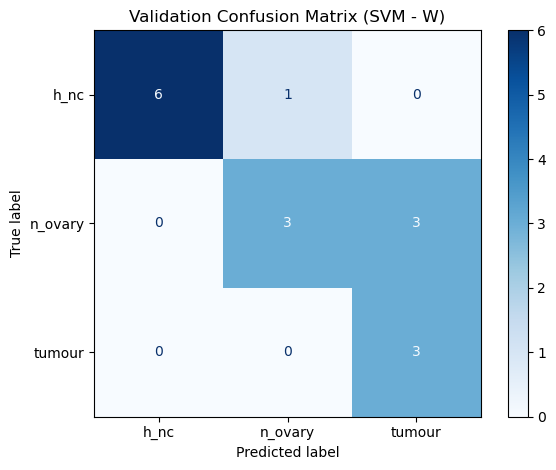

In [8]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy, regionprops, label
from scipy.stats import skew, kurtosis
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# ------------------- JSON Helper -------------------
def load_coco_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def build_annotation_index(coco_data):
    img_id_to_file = {img['id']: img['file_name'] for img in coco_data['images']}
    cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}
    file_to_annotations = defaultdict(list)
    for ann in coco_data['annotations']:
        filename = img_id_to_file[ann['image_id']]
        ann['category_name'] = cat_id_to_name.get(ann['category_id'], "unknown")
        file_to_annotations[filename].append(ann)
    return file_to_annotations

# ------------------- Feature Extractors -------------------
def create_category_mask(image_size, annotations, category):
    mask = Image.new('1', image_size, 0)
    draw = ImageDraw.Draw(mask)
    for ann in annotations:
        if ann['category_name'] != category:
            continue
        for seg in ann.get('segmentation', []):
            points = [(seg[i], seg[i + 1]) for i in range(0, len(seg), 2)]
            draw.polygon(points, fill=1)
    return np.array(mask)

def compute_texture_features(region_pixels):
    if region_pixels.ndim == 3:
        gray = rgb2gray(region_pixels) * 255
    else:
        gray = region_pixels
    gray = gray.astype(np.uint8)
    if gray.size < 100 or gray.ndim == 1:
        return None
    patch_size = min(gray.shape[0], gray.shape[1], 64)
    patch = gray[:patch_size, :patch_size]
    glcm = graycomatrix(patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    flat = patch.flatten()
    return {
        "Mean": np.mean(flat),
        "Median": np.median(flat),
        "Std": np.std(flat),
        "Min": np.min(flat),
        "Max": np.max(flat),
        "Skewness": skew(flat),
        "Kurtosis": kurtosis(flat),
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
        "Entropy": shannon_entropy(patch)
    }

def compute_shape_features(mask):
    props = regionprops(label(mask.astype(int)))
    if not props:
        return None
    p = props[0]
    return {
        "Area": p.area,
        "Perimeter": p.perimeter,
        "Solidity": p.solidity,
        "Extent": p.extent,
        "Eccentricity": p.eccentricity,
        "AspectRatio": p.bbox[3] / p.bbox[2] if p.bbox[2] != 0 else 0
    }

# ------------------- Validation for SVM -------------------
def validate_svm_model_with_subfolders(image_root, json_path, model_dir, mode="W"):
    print(f"\n🔍 Extracting validation features for mode: {mode}...")

    all_modes = {
        "RGBW": ["r_", "g_", "b_", "w_"],
        "RGB": ["r_", "g_", "b_"],
        "W": ["w_"]
    }
    image_types = all_modes[mode]
    categories = ["n_ovary", "h_nc", "tumour"]

    coco_data = load_coco_json(json_path)
    file_to_annotations = build_annotation_index(coco_data)

    all_features = []
    all_labels = []

    for subdir, _, files in os.walk(image_root):
        for file in files:
            if not file.startswith("w_") or not file.endswith(".png"):
                continue
            annotations = file_to_annotations.get(file, [])
            if not annotations:
                continue
            basename = file.replace("w_", "")
            combined_feats_per_cat = defaultdict(list)

            for prefix in image_types:
                fname = f"{prefix}{basename}"
                img_path = os.path.join(subdir, fname)
                if not os.path.exists(img_path):
                    continue
                img = Image.open(img_path).convert("RGB")
                img_np = np.array(img)

                for cat in categories:
                    mask = create_category_mask(img.size, annotations, cat)
                    if not np.any(mask):
                        continue
                    region_pixels = img_np[mask == 1]
                    if region_pixels.ndim == 1:
                        region_pixels = region_pixels[:, np.newaxis]
                    texture_feats = compute_texture_features(region_pixels)
                    shape_feats = compute_shape_features(mask)
                    if texture_feats and shape_feats:
                        full_feats = list(texture_feats.values()) + list(shape_feats.values())
                        combined_feats_per_cat[cat].extend(full_feats)

            for cat, feat_list in combined_feats_per_cat.items():
                if len(feat_list) == len(image_types) * (13 + 6):  # 13 texture + 6 shape per channel
                    all_features.append(feat_list)
                    all_labels.append(cat)

    if not all_features:
        print(f"❌ No features found in test set.")
        return

    print(f"📊 {mode} | Validating on {len(all_features)} regions...")

    # Load model, scaler, and label encoder
    clf = joblib.load(os.path.join(model_dir, "svm_model.pkl"))
    scaler = joblib.load(os.path.join(model_dir, "scaler.pkl"))
    le = joblib.load(os.path.join(model_dir, "label_encoder.pkl"))

    # Preprocess features
    X = scaler.transform(all_features)
    y_true = le.transform(all_labels)

    # Predict
    y_pred = clf.predict(X)

    # Report results
    print("\n✅ Classification Report on Validation Set:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=le.classes_, cmap='Blues'
    )
    plt.title(f"Validation Confusion Matrix (SVM - {mode})")
    plt.tight_layout()
    plt.show()

# ------------------- Entry Point -------------------
if __name__ == "__main__":
    TEST_FOLDER = r"H:\ML_MSI\ROI_based\val_data"
    TEST_JSON = r"H:\ML_MSI\ROI_based\val_data\annotation_27_05_25_vipul_3.json"
    MODEL_DIR = r"H:\ML_MSI\ROI_based\SVM_W"  # Ensure this folder contains svm_model.pkl etc.

    validate_svm_model_with_subfolders(TEST_FOLDER, TEST_JSON, MODEL_DIR, mode="W")
